### Alunos
- Alexandre Candido Souza
- Klarissa Andrade de Morais

# Introdução

In [439]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import math
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.metrics import silhouette_score



plt.style.use('default')

trainData = pd.read_csv('./input/titanic_unsupervised.csv',index_col=0)


Os dados seguiam o seguinte formato:

| Variável | Definição | Valores |
|---|---|---|
| Pclass | Classe do Bilhete | 1 \| 2 \| 3 |
| Sex | Sexo | "male" \| "female" |
| Age | Idade | Anos (fracional se menor que 1)|
| Sibsp | Qtd de irmãos/conjugues a bordo |  |
| Parch | Qtd de pais/filhos a bordo |  |
| Ticket | Numero do Ticket |  |
| Fare | Taxa de passagem |  |
| Cabin | Numero da Cabine |  |
| Embarked | Porto de Embarque | C = Cherbourg, Q = Queenstown, S = Southampton |

Percebemos que háviam muitas idades inválidas. É importante saber quantas e se outras colunas também estavam com dados faltando, e se for o caso, trata-los

In [440]:
print("Training DataSet:")
print(trainData.isna().sum())

Training DataSet:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Usamos o `InterativeImputer` do `Scikit`, que basicamente tenta aproximar o valor que está faltando na coluna idade à partir das outras 2 colunas, iterando recursivamente até chegar em um valor que talvez seja próximo do valor real, podemos parametrizar ele mais, mas deixamos no comportamento padrão.  
> Existem outros métodos de se imputar valores como o `SimpleImputer`, ou simplesmente tentar fazer uma média, moda ou mediana para preencher os valores que estão faltando. Mas no nosso caso o InterativeImputer funcionou bem.

qtd de idades inválidas: 0


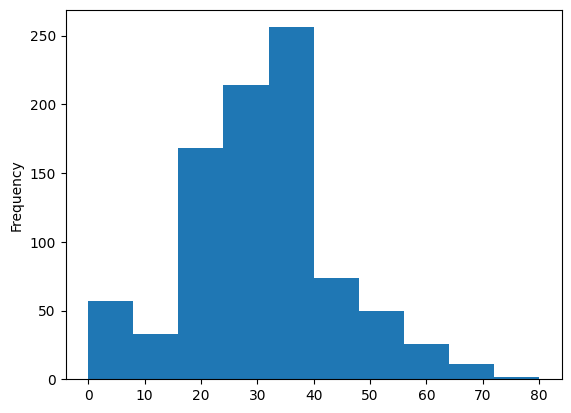

In [441]:
columns = ["SibSp", "Parch", "Age"]
imputer = IterativeImputer(min_value = 0)

imputedValues = imputer.fit_transform(trainData[columns])
correctedValues = pd.DataFrame(imputedValues, columns=columns)
trainData["Age"] = correctedValues["Age"]

trainData["Age"].plot(kind='hist')
print(f"qtd de idades inválidas: {trainData['Age'].isna().sum()}")

Para conseguir plotar o gráfico corretamnete, tem algumas colunas que precisam ser modificadas, pois não estão em valores númericos

In [442]:
#Valores faltando na taxa de embarque => média
trainData["Fare"] = trainData["Fare"].replace(np.NaN, trainData["Fare"].mean())
#converter em valores numéricos
trainData["Sex"] = trainData["Sex"].map({"male": 0, "female": 1})
trainData["Embarked"] = trainData["Embarked"].map({"C": 0, "Q": 1, "S": 2})

#removo qualquer NaN remanescente.
trainData = trainData.dropna().reset_index(drop=True)
trainData = trainData.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis=1)
trainData.describe()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,1.198020,0.470297,35.254141,0.445545,0.440594,76.103301,1.297030
std,0.528205,0.500357,14.955741,0.630490,0.732294,74.759941,0.946789
min,1.000000,0.000000,0.920000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,25.000000,0.000000,0.000000,28.959375,0.000000
50%,1.000000,0.000000,33.500000,0.000000,0.000000,55.000000,2.000000
75%,1.000000,1.000000,46.750000,1.000000,1.000000,89.776050,2.000000
max,3.000000,1.000000,80.000000,3.000000,4.000000,512.329200,2.000000


Criamos essa coluna temporaria "FamilyCount" somando a qtd de filhos e de conjugues ao passageiro
O dado mais relevante é saber se o passageiro está sozinho ou não. Por isso só ele é mantido

In [443]:
trainData["FamilyCount"] = trainData['SibSp'] + trainData['Parch'] + 1
trainData['IsAlone'] = trainData["FamilyCount"] == 1

trainData = trainData.drop(["SibSp","Parch"], axis=1)

## Visualizando a Distribuição dos Dados
Após todos os processos de tratamento, temos os parametros finais a ser utilizado pelo algoritmo. Agora, iremos visualizar brevemente a nova distribuição dos dados de custo que foram mapeados:

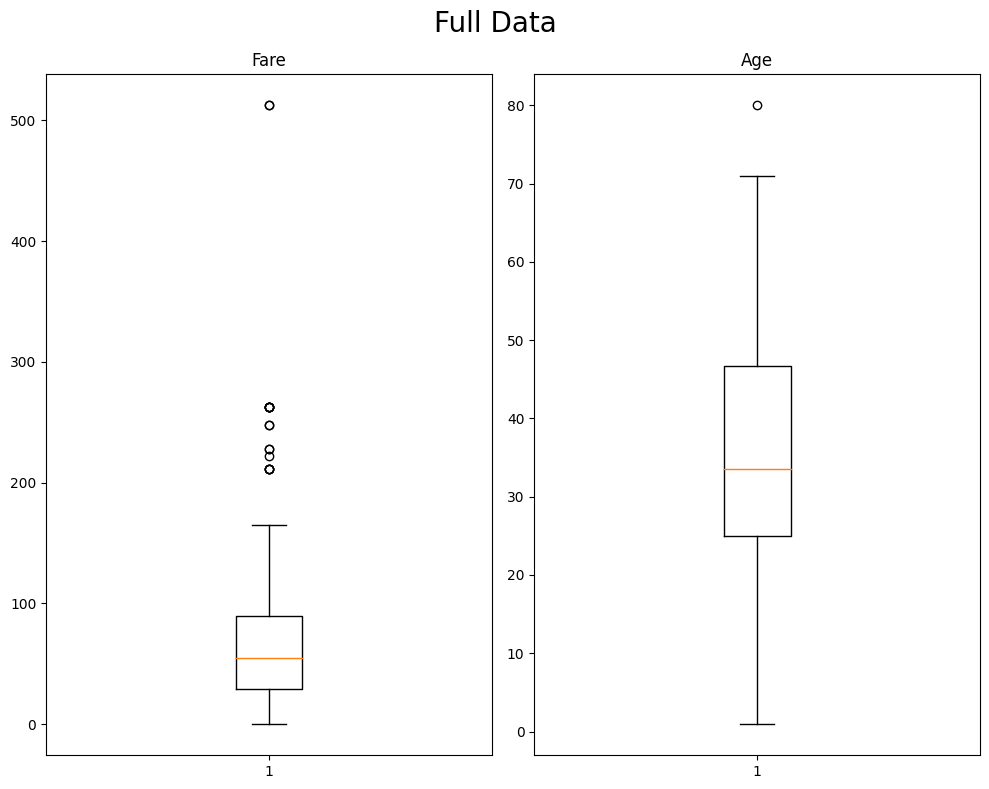

In [444]:
params = ["Fare", "Age"]
count = len(params)
width = 2
height = int(count/width)
figure, axis = plt.subplots(height, width, figsize=(10, 8))
figure.suptitle("Full Data", fontsize=20)

for i,attr in enumerate(params):
    values = trainData[attr].astype(float)
    axis[i].boxplot(values)
    axis[i].set_title(attr)

plt.tight_layout()
plt.show()

Percebemos que existem valores bem distantes no atributo "Fare". Como estão em pouquissima quantidade, nós resolvemos remover-los para manter a consistência

In [445]:
trainData = trainData.drop(trainData[trainData["Fare"] > 200].index)

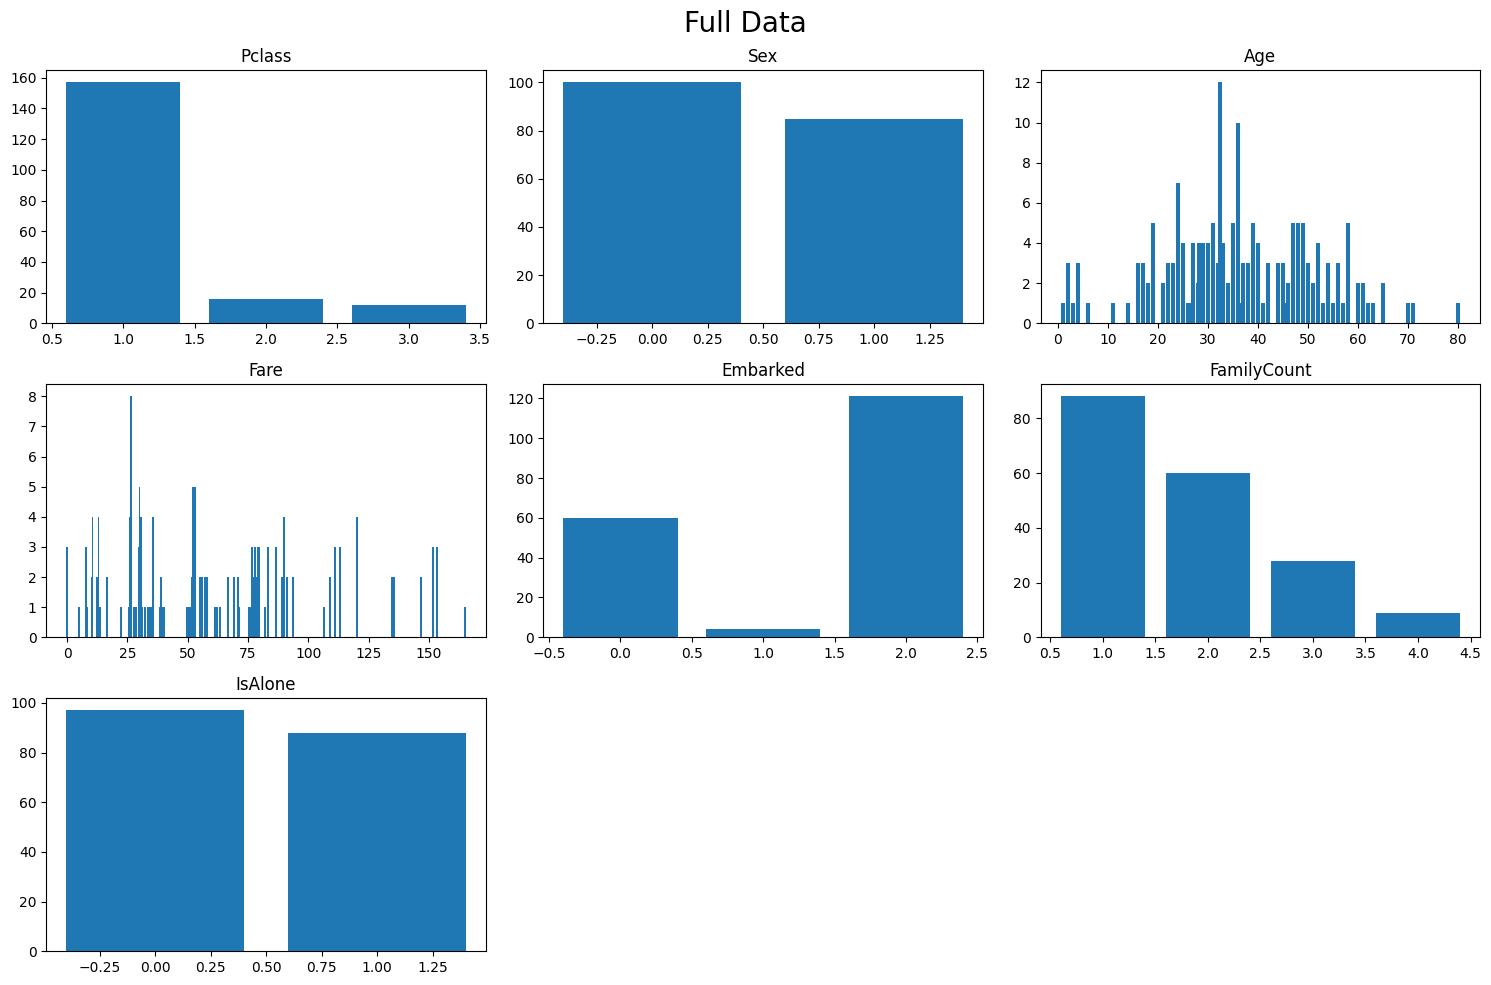

In [446]:
count = len(trainData.columns)
width = 3
figure, axis = plt.subplots(int((count + width - 1) / width), width, figsize=(15, 10))
figure.suptitle("Full Data", fontsize=20)

for i, attr in enumerate(trainData.columns):
    x, y = divmod(i, width)
    labels = trainData[attr].astype(float).unique()
    labels.sort()
    values = trainData[attr].value_counts().sort_index()
    axis[x, y].bar(labels, values)
    axis[x, y].set_title(attr)

# Hide empty subplots
for i in range(count, int((count + width - 1) / width) * width):
    x, y = divmod(i, width)
    figure.delaxes(axis[x, y])

plt.tight_layout()
plt.show()


## Normalizando os dados
Normalizamos os dados do conjunto de dados para garantir que os algoritmos de clusterização, que dependem fortemente da distância entre os centroides, não sejam distorcidos por valores extremos. Ao transformar as características em uma escala comum, cada uma contribui igualmente para a distância entre os centroides, assegurando uma análise mais equilibrada e precisa.

In [447]:
trainData = pd.DataFrame(normalize(trainData, axis=0), columns=trainData.columns)
trainData.head()

,Pclass,Sex,Age,Fare,Embarked,FamilyCount,IsAlone
0,0.055132,0.108465,0.072120,0.075138,0.000000,0.074329,0.0000
1,0.055132,0.108465,0.066426,0.055971,0.090536,0.074329,0.0000
2,0.055132,0.000000,0.102486,0.054667,0.090536,0.037165,0.1066
3,0.165395,0.108465,0.007592,0.017603,0.090536,0.111494,0.0000
4,0.055132,0.108465,0.110077,0.027986,0.090536,0.037165,0.1066


## K-Means

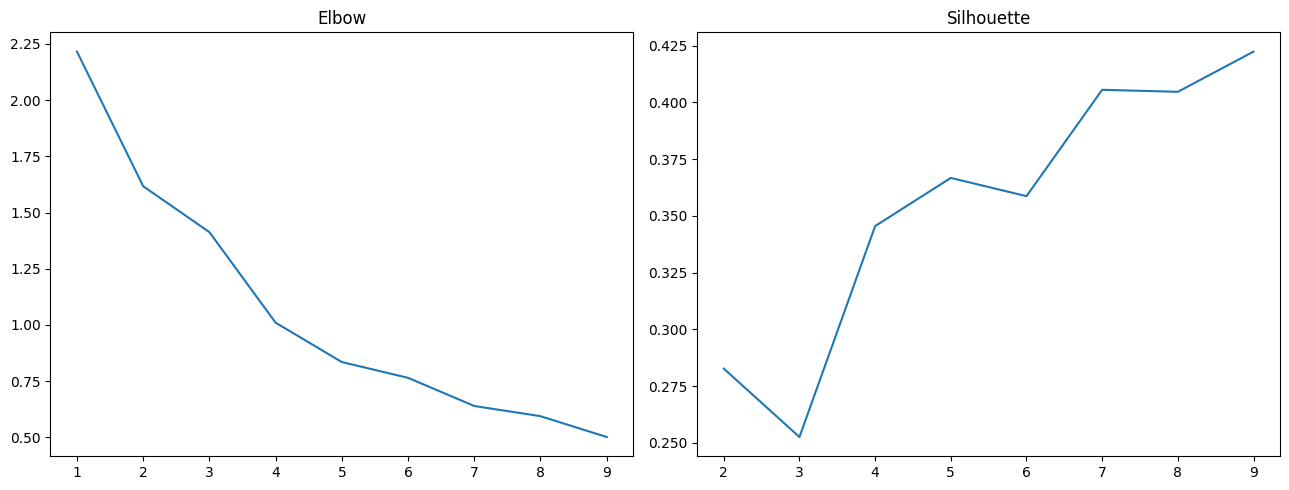

In [448]:

k_range = list(range(1, 10))
scores = {"elbow": [], "silhouette": []}

for i in k_range:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(trainData)
    scores["elbow"].append([i, kmeans.inertia_])
    if i == 1: continue
    scores["silhouette"].append([i, silhouette_score(trainData, kmeans.labels_)])

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
for i, (score_name, score_data) in enumerate(scores.items()):
    score_data = np.array(score_data)
    axes[i].plot(score_data[:, 0], score_data[:, 1])
    axes[i].set_title(score_name.capitalize())

plt.tight_layout()
plt.show()


## Métricas

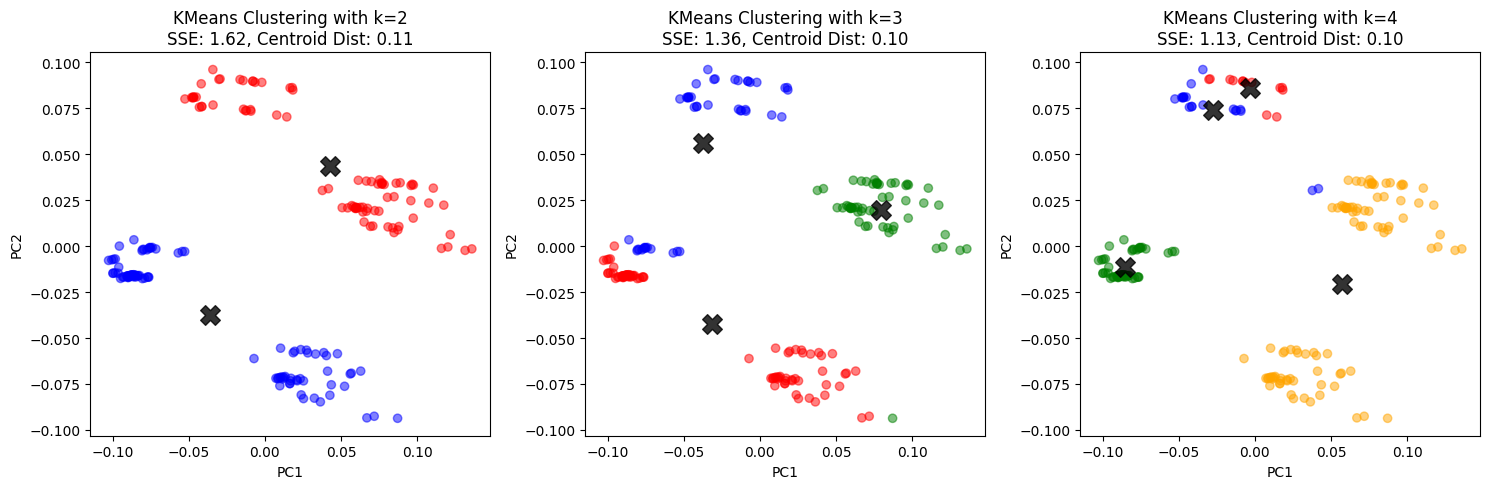

In [449]:
k_values = [2, 3, 4]

fig, axes = plt.subplots(1, len(k_values), figsize=(15, 5))

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(trainData)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(trainData.values)

    colors = np.array(['red', 'blue', 'green', 'orange', 'pink'])  # Adjust colors if k > 4
    axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=colors[kmeans.labels_], alpha=0.5)
    axes[i].scatter(pca.transform(kmeans.cluster_centers_)[:, 0], pca.transform(kmeans.cluster_centers_)[:, 1],
                    c='black', s=200, alpha=0.8, marker='X')
    axes[i].set_title(f'KMeans Clustering with k={k}')
    #cluster distances
    sse = kmeans.inertia_
    centroids_dist = np.linalg.norm(kmeans.cluster_centers_[0] - kmeans.cluster_centers_[1])  # Euclidean distance
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
    axes[i].set_title(f'KMeans Clustering with k={k}\nSSE: {sse:.2f}, Centroid Dist: {centroids_dist:.2f}')


plt.tight_layout()
plt.show()